In [1]:
!pip install -q sacrebleu
!pip install -q rouge-score
!pip install -q evaluate
!pip install -q bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.8 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoProcessor
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
import numpy as np
from sacrebleu import corpus_bleu
from rouge_score import rouge_scorer
import evaluate

### Setting up model on GPU

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# loading model and tokenizer
# model = OpenGVLab/InternVL2_5-1B
model_path = "OpenGVLab/InternVL2_5-1B"

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True, use_fast=False)
model = AutoModel.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    use_flash_attn=True
).to(device)
model.eval()

# i am manually setting the img_context_token_id to avoid assertion error
model.img_context_token_id = tokenizer.convert_tokens_to_ids('<IMG_CONTEXT>')
print(f"IMG_CONTEXT_TOKEN ID set to: {model.img_context_token_id}")

Using device: cuda


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/744 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_internvl_chat.py: 0.00B [00:00, ?B/s]

configuration_intern_vit.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B:
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B:
- configuration_internvl_chat.py
- configuration_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
`torch_dtype` is deprecated! Use `dtype` instead!


modeling_internvl_chat.py: 0.00B [00:00, ?B/s]

conversation.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B:
- conversation.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_intern_vit.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B:
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/InternVL2_5-1B:
- modeling_internvl_chat.py
- conversation.py
- modeling_intern_vit.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


FlashAttention2 is not installed.


model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

IMG_CONTEXT_TOKEN ID set to: 151667


### Downloading dataset

In [4]:
dataset = load_dataset("Fakhraddin/NLMCXR")
split_to_use = "validation"
data = dataset[split_to_use]
print(f"Loaded {len(data)} examples.")

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
BATCH_SIZE = 32

def build_transform(input_size=448):
    return T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

transform = build_transform()

README.md:   0%|          | 0.00/642 [00:00<?, ?B/s]

data/train-00000-of-00003-627ed4d457a264(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00001-of-00003-b7ef6c3b205887(…):   0%|          | 0.00/364M [00:00<?, ?B/s]

data/train-00002-of-00003-738198d486559e(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/validation-00000-of-00001-d17faea78(…):   0%|          | 0.00/273M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5925 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1505 [00:00<?, ? examples/s]

Loaded 1505 examples.


### Batched generation and prompts for InternVL

In [5]:
BATCH_SIZE = 32

# collate function for batching
def collate_fn(batch):
    images = []
    prompts = []
    raw_texts = []

    # defining the visual token sequence manually
    # InternVL 2.5 uses 256 tokens for a 448x448 image
    # Format: <img> + <IMG_CONTEXT>*256 + </img>
    visual_tokens = "<img>" + "<IMG_CONTEXT>" * 256 + "</img>"

    for item in batch:
        # resizing the image
        image = item["image"]
        pixel_values = transform(image)
        images.append(pixel_values)

        # adding the visual tokens in the prompt
        question = "Describe this medical image."
        prompt = f"{visual_tokens}\n{question}"
        prompts.append(prompt)
        raw_texts.append(item["text"])

    # stack images: [Batch, 3, 448, 448]
    pixel_values = torch.stack(images)

    # tokenize input with prompts
    model_inputs = tokenizer(
        prompts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    )

    return model_inputs, pixel_values, raw_texts

eval_dataloader = DataLoader(data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

preds, refs = [], []
print(f"Starting generation with batch size: {BATCH_SIZE}...")

with torch.no_grad():
    for model_inputs, pixel_values, batch_texts in tqdm(eval_dataloader, desc="Generating"):
        input_ids = model_inputs["input_ids"].to(device)
        attention_mask = model_inputs["attention_mask"].to(device)

        # bfloat16 should be used for images since model uses it
        pixel_values = pixel_values.to(device).to(torch.bfloat16)

        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            max_new_tokens=50,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )

        batch_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        preds.extend(batch_preds)
        refs.extend(batch_texts)

print(f"Generated {len(preds)} captions.")

Starting generation with batch size: 32...


Generating: 100%|██████████| 48/48 [03:05<00:00,  3.87s/it]

Generated 1505 captions.


### Computing performance metrics

In [6]:
print(f"Evaluating {len(preds)} samples...")


## COsine Simiarity
print("Computing Cosine Similarity...")

# using bert-base-uncased for embeddings
eval_model_name = "bert-base-uncased"
eval_tokenizer = AutoTokenizer.from_pretrained(eval_model_name)
eval_model = AutoModel.from_pretrained(eval_model_name).to(device)
eval_model.eval()

def get_embeddings_batched(text_list, batch_size=128):
    """
    Computes CLS embeddings for a list of texts using batching to maximize GPU usage.
    """
    all_embs = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i : i + batch_size]
        inputs = eval_tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        with torch.no_grad():
            outputs = eval_model(**inputs)

        embs = outputs.last_hidden_state[:, 0, :].cpu()
        all_embs.append(embs)

    return torch.cat(all_embs, dim=0)

# Compute embeddings
pred_embs = get_embeddings_batched(preds)
ref_embs = get_embeddings_batched(refs)

# Compute Cosine Similarity
# cosine_similarity expects tensors of shape (N, D)
cosine_sims = torch.nn.functional.cosine_similarity(pred_embs, ref_embs, dim=1)
avg_cosine = cosine_sims.mean().item()

print(f"Done. Avg Cosine: {avg_cosine:.4f}")

# BLEU Score
print("Computing BLEU...")
# sacrebleu expects references as a list of lists (for multiple refs per image)
avg_bleu = corpus_bleu(preds, [refs]).score

# ROUGE Score
print("Computing ROUGE...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for r, p in zip(refs, preds):
    scores = scorer.score(r, p)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

## BERT SCore
print("Computing BERTScore...")
bertscore_metric = evaluate.load("bertscore")
results = bertscore_metric.compute(
    predictions=preds,
    references=refs,
    model_type="bert-base-uncased",
    batch_size=64,
    device=device
)

avg_bertscore = np.mean(results["f1"])

print("\n" + "="*40)
print(f"  Evaluation Report: InternVL2.5-1B")
print("="*40)
print(f"Avg. Cosine Similarity: {avg_cosine:.4f}")
print(f"Avg. BLEU:              {avg_bleu:.4f}")
print(f"Avg. ROUGE-1:           {avg_rouge1:.4f}")
print(f"Avg. ROUGE-2:           {avg_rouge2:.4f}")
print(f"Avg. ROUGE-L:           {avg_rougeL:.4f}")
print(f"Avg. BERTScore (F1):    {avg_bertscore:.4f}")
print("="*40)

Evaluating 1505 samples...
Computing Cosine Similarity...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Done. Avg Cosine: 0.6342
Computing BLEU...
Computing ROUGE...
Computing BERTScore...



  Evaluation Report: InternVL2.5-1B
Avg. Cosine Similarity: 0.6342
Avg. BLEU:              0.3246
Avg. ROUGE-1:           0.0740
Avg. ROUGE-2:           0.0060
Avg. ROUGE-L:           0.0552
Avg. BERTScore (F1):    0.3688


### Plotting boxplot

/tmp/ipython-input-2296115851.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)


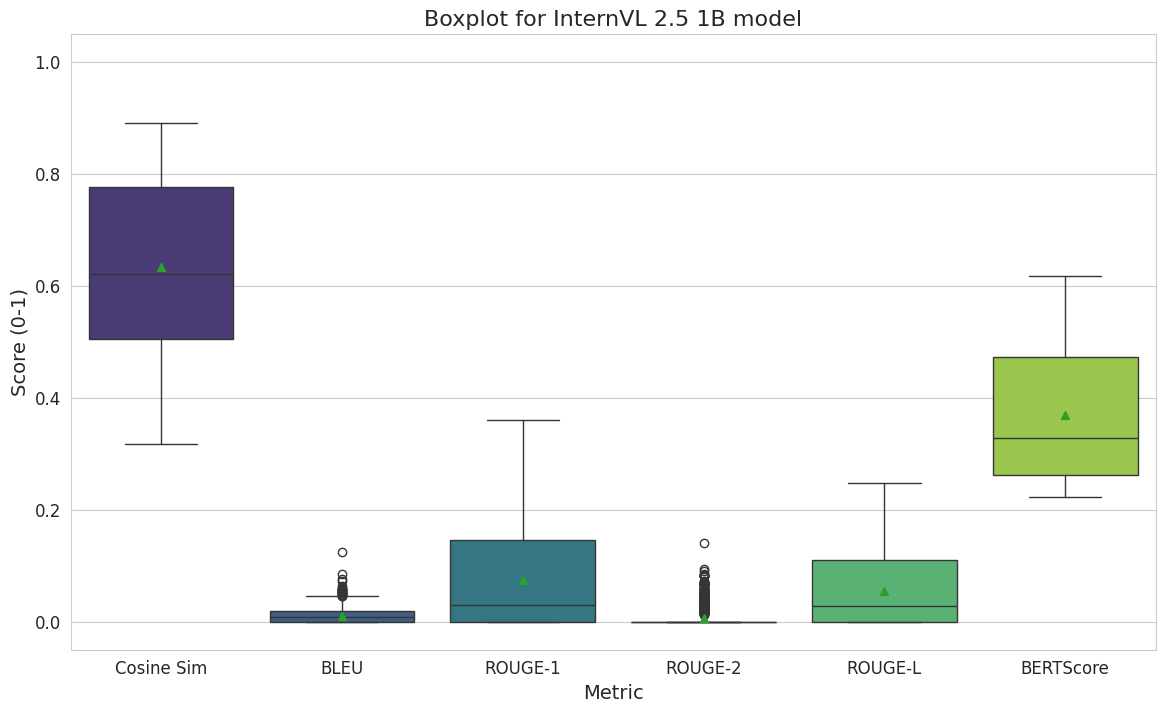


===== Statistical Summary =====
              mean     std     min     50%     max
Cosine Sim  0.6342  0.1471  0.3178  0.6203  0.8905
BLEU        0.0105  0.0126  0.0000  0.0081  0.1245
ROUGE-1     0.0740  0.0881  0.0000  0.0290  0.3600
ROUGE-2     0.0060  0.0153  0.0000  0.0000  0.1404
ROUGE-L     0.0552  0.0639  0.0000  0.0282  0.2472
BERTScore   0.3688  0.1117  0.2235  0.3284  0.6177


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sacrebleu import sentence_bleu

cosine_scores = cosine_sims.cpu().numpy()
bert_scores = results["f1"]

# Calculate Sentence-Level BLEU for distribution

bleu_scores = []
for p, r in zip(preds, refs):
    # normalizing the bleu values to 0 -1
    score = sentence_bleu(p, [r]).score
    bleu_scores.append(score / 100.0)

# Creating a DataFrame combining all metrics
df_metrics = pd.DataFrame({
    "Cosine Sim": cosine_scores,
    "BLEU": bleu_scores,
    "ROUGE-1": rouge1_scores,
    "ROUGE-2": rouge2_scores,
    "ROUGE-L": rougeL_scores,
    "BERTScore": bert_scores
})

# plotting
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Transforming data to long format for Seaborn
df_melted = df_metrics.melt(var_name="Metric", value_name="Score")
ax = sns.boxplot(data=df_melted, x="Metric", y="Score", palette="viridis", showmeans=True)
plt.title("Boxplot for InternVL 2.5 1B model", fontsize=16)
plt.ylabel("Score (0-1)", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print("\n===== Statistical Summary =====")
print(df_metrics.describe().T[['mean', 'std', 'min', '50%', 'max']].round(4))